In [1]:
print('Hello, world!')

Hello, world!


In [2]:
import os


In [3]:
from langgraph.graph import MessagesState,StateGraph, END, START
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import tools_condition # this is the checker for the if you got a tool back
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from typing import Annotated, TypedDict
import operator
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition # this is the checker for the
from langgraph.prebuilt import ToolNode

In [4]:

from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")
     

In [5]:
llm.invoke('Who is the president of the Sri Lanka?')

AIMessage(content='The current president of Sri Lanka is **Ranil Wickremesinghe**. \n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 18, 'total_tokens': 37, 'completion_time': 0.034545455, 'prompt_time': 0.001918437, 'queue_time': 0.193466983, 'total_time': 0.036463892}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--8bce5155-99b8-43ff-bf14-bade6bae748d-0', usage_metadata={'input_tokens': 18, 'output_tokens': 19, 'total_tokens': 37})

In [6]:
def multiply(a: int, b: int) -> int:
    """
    Multiply a and b.
    Args:
        a: first int
        b: second int
    """
    return a * b

In [7]:
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

In [8]:
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [9]:
from langchain_community.tools.tavily_search import TavilySearchResults


search = TavilySearchResults()


In [10]:
tools = [add, multiply, divide, search]


In [11]:
llm_with_tools=llm.bind_tools(tools)


In [12]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search and performing arithmetic on a set of inputs.")

In [13]:
def reasoner(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}
     

In [14]:
# Graph
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("reasoner", reasoner)

builder.add_node("tools", ToolNode(tools)) # for the tools

# Add edges
builder.add_edge(START, "reasoner")

builder.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)

builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

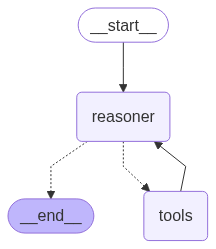

In [15]:

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [16]:
messages = [HumanMessage(content="What is 2 times of narendramodi's age?")]


In [17]:
messages = react_graph.invoke({"messages": messages})


In [18]:

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 times of narendramodi's age?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_h9y7)
 Call ID: call_h9y7
  Args:
    query: narendra modi's age
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Narendra Modi Biography, Age, Education, Family, Political - Only IAS", "url": "https://pwonlyias.com/narendra-modi/", "content": "Narendra Modi, the present serving Prime Minister of India, was born on September 17, 1950. At present, in 2024, Narendra Modi age is 74. Throughout his political career, Modi has been a significant figure, known for his leadership, vision, and constructive policies. His journey from humble beginnings to the highest office in the country has been marked by both praise and criticism, shaping the political landscape of India.\

In [19]:
#Creating a finance BOT
import yfinance as yf

def get_stock_price(ticker: str) -> float:
    """Gets a stock price from Yahoo Finance.

    Args:
        ticker: ticker str
    """
    # """This is a tool for getting the price of a stock when passed a ticker symbol"""
    stock = yf.Ticker(ticker)
    return stock.info['previousClose']

ModuleNotFoundError: No module named 'websockets.sync'

In [ ]:
get_stock_price("AAPL")


197.49

In [ ]:
def reasoner(state):
    query = state["query"]
    messages = state["messages"]
    # System message
    sys_msg = SystemMessage(content="You are a helpful assistant tasked with using search, the yahoo finance tool and performing arithmetic on a set of inputs.")
    message = HumanMessage(content=query)
    messages.append(message)
    result = [llm_with_tools.invoke([sys_msg] + messages)]
    return {"messages":result}
     

In [ ]:
tools = [add, multiply, divide, search, get_stock_price]


In [ ]:
llm_with_tools = llm.bind_tools(tools)


In [ ]:

class GraphState(TypedDict):
    """State of the graph."""
    query: str
    finance: str
    final_answer: str
    # intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]
    messages: Annotated[list[AnyMessage], operator.add]

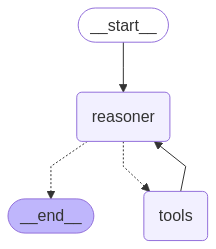

In [ ]:
# Graph
workflow = StateGraph(GraphState)

# Add Nodes
workflow.add_node("reasoner", reasoner)
workflow.add_node("tools", ToolNode(tools)) # for the tools

# Add Edges
workflow.add_edge(START, "reasoner")

workflow.add_conditional_edges(
    "reasoner",
    # If the latest message (result) from node reasoner is a tool call -> tools_condition routes to tools
    # If the latest message (result) from node reasoner is a not a tool call -> tools_condition routes to END
    tools_condition,
)
workflow.add_edge("tools", "reasoner")
react_graph = workflow.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [ ]:
response = react_graph.invoke({"query": "What is the stock price of Apple add 1000?", "messages": []})


In [ ]:

for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_gkdc)
 Call ID: call_gkdc
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

197.49
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message ==================================
Tool Calls:
  get_stock_price (call_e1z1)
 Call ID: call_e1z1
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_price

197.49
================================ Human Message =================================

What is the stock price of Apple add 1000?
================================== Ai Message =====================